In [3]:
# # 토큰 40 이하 행을 제거
#
# import os
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from transformers import AutoTokenizer
#
# # === CONFIG ===
# MIN_LEN = 40
# SAVE_DIR = "../Data/split"   # ✅ 저장 경로 변경
# os.makedirs(SAVE_DIR, exist_ok=True)
#
# tok = AutoTokenizer.from_pretrained("roberta-base", use_fast=True)
#
# # === 1) Load & Clean ===
# df = pd.read_csv("../Data/processed/reddit_post_clean.csv")  # columns: text, mbti
# df["mbti"] = df["mbti"].str.upper().str.strip()
#
# # === 2) Compute token length and filter ===
# def tok_len(text):
#     return len(tok(text, add_special_tokens=True, truncation=False)["input_ids"])
#
# df["tok_len"] = df["body"].astype(str).apply(tok_len)
# before = len(df)
# df = df[df["tok_len"] >= MIN_LEN].copy()
#
# print(f"Removed (len<{MIN_LEN}): {before - len(df)} / {before} "
#       f"({(before-len(df))/before:.1%})")
#
# # === 3) Class-wise stats ===
# stats = df.groupby("mbti")["tok_len"].agg(["count","mean"])
# print(stats.sort_values("count", ascending=False).head(10))
#
# # === 4) Stratified split (60/20/20) ===
# train_df, temp = train_test_split(
#     df, test_size=0.40, stratify=df["mbti"], random_state=42
# )
# val_df, test_df = train_test_split(
#     temp, test_size=0.50, stratify=temp["mbti"], random_state=42
# )
#
# print(f"train: {len(train_df)}, val: {len(val_df)}, test: {len(test_df)}")
#
# # === 5) Save ===
# for name, d in [("train.csv", train_df), ("val.csv", val_df), ("test.csv", test_df)]:
#     path = os.path.join(SAVE_DIR, name)
#     d.drop(columns=["tok_len"]).to_csv(path, index=False)
#     print(f"✅ Saved to: {path} ({len(d)} rows)")

Token indices sequence length is longer than the specified maximum sequence length for this model (599 > 512). Running this sequence through the model will result in indexing errors


Removed (len<40): 8666178 / 12910571 (67.1%)
       count        mean
mbti                    
INFP  913405   95.731529
INTP  858150   97.228480
INFJ  745216   98.633461
INTJ  584109  101.452797
ENTP  384393   97.528953
ENTJ  214232   99.967222
ISTP  136645   98.263720
ENFP  134915   98.113827
ENFJ   96081   97.355003
ISFJ   50154   99.988914
train: 2546635, val: 848879, test: 848879
✅ Saved to: ../Data/split/train.csv (2546635 rows)
✅ Saved to: ../Data/split/val.csv (848879 rows)
✅ Saved to: ../Data/split/test.csv (848879 rows)


In [5]:
#40토큰 이하 제거, 256 이상 제거
import os
import math
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer


# === CONFIG ===
MIN_LEN = 40
MAX_LEN = 256
SAVE_DIR = "../Data/split"
CSV_PATH = "../Data/processed/reddit_post_clean.csv"  # 로컬 경로
os.makedirs(SAVE_DIR, exist_ok=True)

tok = AutoTokenizer.from_pretrained("roberta-base", use_fast=True)

# 1) Load
df = pd.read_csv(CSV_PATH)  # columns: body, mbti
df["mbti"] = df["mbti"].str.upper().str.strip()
df["body"] = df["body"].astype(str)

# 2) Batched token length (훨씬 빠름)
def batched_token_lengths(texts, batch_size=4096):
    lengths = []
    n = len(texts)
    for i in range(0, n, batch_size):
        batch = texts[i:i+batch_size].tolist()
        enc = tok(batch, add_special_tokens=True, truncation=False, return_length=True)
        # fast tokenizer면 enc["length"] 제공됨
        lengths.extend(enc["length"])
    return lengths

df["tok_len"] = batched_token_lengths(df["body"])

before = len(df)
df = df[(df["tok_len"] >= MIN_LEN) & (df["tok_len"] <= MAX_LEN)].copy()
print(f"Removed out-of-range rows: {before - len(df)} / {before} ({(before-len(df))/before:.1%})")
print(f"Remaining rows: {len(df)}")

# 3) 가벼운 통계(선택)
stats = df.groupby("mbti")["tok_len"].agg(["count", "mean", "min", "max"])
print(stats.sort_values("count", ascending=False).head(10))

# 4) Stratified split (60/20/20)
train_df, temp = train_test_split(df, test_size=0.40, stratify=df["mbti"], random_state=42)
val_df, test_df = train_test_split(temp, test_size=0.50, stratify=temp["mbti"], random_state=42)

print(f"train: {len(train_df)}, val: {len(val_df)}, test: {len(test_df)}")

# 5) Save
for name, d in [("train.csv", train_df), ("val.csv", val_df), ("test.csv", test_df)]:
    path = os.path.join(SAVE_DIR, name)
    d.drop(columns=["tok_len"]).to_csv(path, index=False)
    print(f"✅ Saved to: {path} ({len(d)} rows)")

Token indices sequence length is longer than the specified maximum sequence length for this model (599 > 512). Running this sequence through the model will result in indexing errors


Removed out-of-range rows: 8872845 / 12910571 (68.7%)
Remaining rows: 4037726
       count       mean  min  max
mbti                             
INFP  871981  83.116677   40  256
INTP  817046  83.854741   40  256
INFJ  709093  85.405393   40  256
INTJ  551855  85.816986   40  256
ENTP  365653  83.909403   40  256
ENTJ  203053  85.725284   40  256
ISTP  129299  82.795582   40  256
ENFP  128489  85.022881   40  256
ENFJ   91420  83.874579   40  256
ISFJ   47561  85.904396   40  256
train: 2422635, val: 807545, test: 807546
✅ Saved to: ../Data/split/train.csv (2422635 rows)
✅ Saved to: ../Data/split/val.csv (807545 rows)
✅ Saved to: ../Data/split/test.csv (807546 rows)


In [7]:
# ClusterCentroids로 Train 데이터셋만 언더샘플링
import os
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import normalize
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import pairwise_distances
from collections import Counter, defaultdict
from sentence_transformers import SentenceTransformer

# === CONFIG ===
SPLIT_DIR   = "../Data/split"      # 이미 40~256 토큰 필터링된 split
SAVE_DIR    = "../Data/split_cc"
MODEL_NAME  = "sentence-transformers/all-MiniLM-L6-v2"  # 384-d
RANDOM_STATE = 42
# --- 추가 CONFIG ---
KMEANS_STAGE1 = 3000   # 1단계 거친 클러스터 개수(2000~5000 사이 권장)
EMB_BATCH = 512        # CPU면 256~512 권장, GPU면 1024 가능

# 언더샘플링 타깃: 각 클래스 당 몇 개로 맞출지
MIN_PER_CLASS = 10000     # 너무 작아지지 않게 최소 보장(데이터 상황에 맞춰 조정)
MAX_PER_CLASS = 120000    # 예: 2_000 같은 상한을 줄 수도 있음. 없으면 최소 클래스 기준 사용

os.makedirs(SAVE_DIR, exist_ok=True)

# 1) Load already-filtered splits
train_df = pd.read_csv(os.path.join(SPLIT_DIR, "train.csv"))
val_df   = pd.read_csv(os.path.join(SPLIT_DIR, "val.csv"))
test_df  = pd.read_csv(os.path.join(SPLIT_DIR, "test.csv"))

for d in (train_df, val_df, test_df):
    d["mbti"] = d["mbti"].str.upper().str.strip()
    d["body"] = d["body"].astype(str)

print(f"loaded (filtered) -> train:{len(train_df):,}  val:{len(val_df):,}  test:{len(test_df):,}")

# # 2) Sentence-BERT embeddings for TRAIN only
# device = "cuda" if torch.cuda.is_available() else "cpu"
# st_model = SentenceTransformer(MODEL_NAME, device=device)
#
# train_texts = train_df["body"].tolist()
# X = st_model.encode(train_texts, batch_size=EMB_BATCH, show_progress_bar=True, convert_to_numpy=True)
# X = normalize(X, norm="l2", axis=1)   # 코사인≈L2(정규화)로 근사
# y = train_df["mbti"].values

# 2) Sentence-BERT embeddings for TRAIN only
device = "cuda" if torch.cuda.is_available() else "cpu"
st_model = SentenceTransformer(MODEL_NAME, device=device)

train_texts = train_df["body"].tolist()
X = st_model.encode(train_texts, batch_size=EMB_BATCH,
                    show_progress_bar=True, convert_to_numpy=True)
X = normalize(X, norm="l2", axis=1)   # 코사인≈L2(정규화)
y = train_df["mbti"].values

counts = Counter(y)
min_count = min(counts.values())

if MAX_PER_CLASS is None:
    target_per_class_value = max(MIN_PER_CLASS, min_count)
else:
    target_per_class_value = np.clip(min_count, MIN_PER_CLASS, MAX_PER_CLASS)

target_per_class = {c: min(target_per_class_value, counts[c]) for c in counts}

cls_to_idx = defaultdict(list)
for i, c in enumerate(y):
    cls_to_idx[c].append(i)

selected_idx = []

for c, idxs in cls_to_idx.items():
    idxs = np.array(idxs)
    k_target = target_per_class[c]

    # 소수 클래스거나 이미 작으면 그대로 보존
    if len(idxs) <= k_target:
        selected_idx.extend(idxs.tolist())
        continue

    Xc = X[idxs]

    # 1단계: 거친 KMeans로 크게 묶기
    k1 = min(KMEANS_STAGE1, len(idxs))
    km = MiniBatchKMeans(
        n_clusters=k1, random_state=RANDOM_STATE, batch_size=4096,
        n_init=1, max_iter=50, init="k-means++"
    )
    labels = km.fit_predict(Xc)
    centers = km.cluster_centers_

    # 클러스터별 크기 비율로 k_target 배분
    _, cluster_sizes = np.unique(labels, return_counts=True)
    frac = cluster_sizes / cluster_sizes.sum()
    take = (frac * k_target).astype(int)

    # 라운딩 오차 보정: 남은 몫을 큰 잔여부터 채움
    while take.sum() < k_target:
        rem = k_target - take.sum()
        add_idx = np.argsort((frac * k_target) - take)[-rem:]
        take[add_idx] += 1

    # 각 클러스터에서 센터와 가장 가까운 실제 샘플 need개 선택
    for cl in range(k1):
        need = take[cl]
        if need == 0:
            continue
        cl_mask = (labels == cl)
        cl_idxs = idxs[cl_mask]
        Xcl = Xc[cl_mask]
        d = pairwise_distances(Xcl, centers[cl][None, :], metric="euclidean").ravel()
        pick_local = np.argsort(d)[:need]
        selected_idx.extend(cl_idxs[pick_local].tolist())

selected_idx = sorted(set(selected_idx))
train_balanced_df = train_df.iloc[selected_idx].copy().reset_index(drop=True)

# 4) Save
train_balanced_df.to_csv(os.path.join(SAVE_DIR, "train_cc.csv"), index=False)
val_df.to_csv(os.path.join(SAVE_DIR, "val.csv"), index=False)
test_df.to_csv(os.path.join(SAVE_DIR, "test.csv"), index=False)

# 5) Logs
print("\n[train original counts]")
print(train_df["mbti"].value_counts().sort_values(ascending=False).head(12))
print("\n[train after CC counts]")
print(train_balanced_df["mbti"].value_counts().sort_values(ascending=False).head(12))
print(f"\nSizes -> train_cc: {len(train_balanced_df):,} | val: {len(val_df):,} | test: {len(test_df):,}")

loaded (filtered) -> train:2,422,635  val:807,545  test:807,546


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Batches:   5%|▍         | 224/4732 [32:18<10:50:05,  8.65s/it]


KeyboardInterrupt: 

In [8]:
import pandas as pd
import os

# 원본 폴더 경로
SRC_DIR = "../Data/split"
# 다운샘플 비율
FRACTION = 0.01
# 시드 (재현성용)
SEED = 42

def downsample_csv(filename, frac=FRACTION):
    path = os.path.join(SRC_DIR, filename)
    if not os.path.exists(path):
        print(f"❌ File not found: {path}")
        return

    # CSV 읽기
    df = pd.read_csv(path)
    print(f"✅ Loaded {filename}: {len(df):,} rows")

    # 다운샘플링
    df_small = df.sample(frac=frac, random_state=SEED)
    print(f"→ Downsampled to {len(df_small):,} rows")

    # 저장 (파일명 뒤에 _small 추가)
    base, ext = os.path.splitext(filename)
    out_path = os.path.join(SRC_DIR, f"{base}_small{ext}")
    df_small.to_csv(out_path, index=False)
    print(f"💾 Saved: {out_path}\n")


def main():
    files = ["train_all.csv", "val_all.csv", "test_all.csv"]
    for f in files:
        downsample_csv(f)


if __name__ == "__main__":
    main()

✅ Loaded train_all.csv: 7,667,757 rows
→ Downsampled to 76,678 rows
💾 Saved: ../Data/split/train_all_small.csv

✅ Loaded val_all.csv: 2,485,797 rows
→ Downsampled to 24,858 rows
💾 Saved: ../Data/split/val_all_small.csv

✅ Loaded test_all.csv: 2,757,017 rows
→ Downsampled to 27,570 rows
💾 Saved: ../Data/split/test_all_small.csv



In [1]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.2/37.2 MB 22.5 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


loaded train: 2,422,635
viz class=INFP sample=2,000


/Users/seojunha/PycharmProjects/MBTI_Prediction/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 8/8 [00:11<00:00,  1.47s/it]
/Users/seojunha/PycharmProjects/MBTI_Prediction/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


repr points: 15
selected (centroid-nearest) points: 90


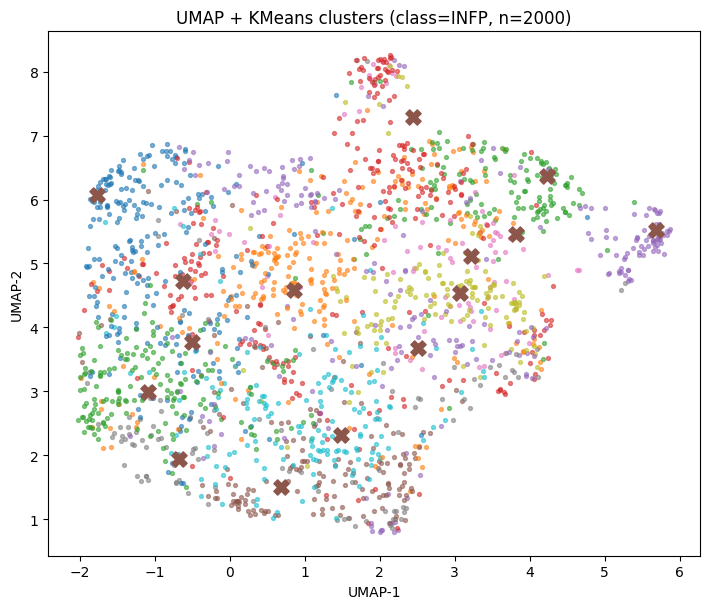

saved: ../Data/split_cc_viz/viz_INFP_clusters.png


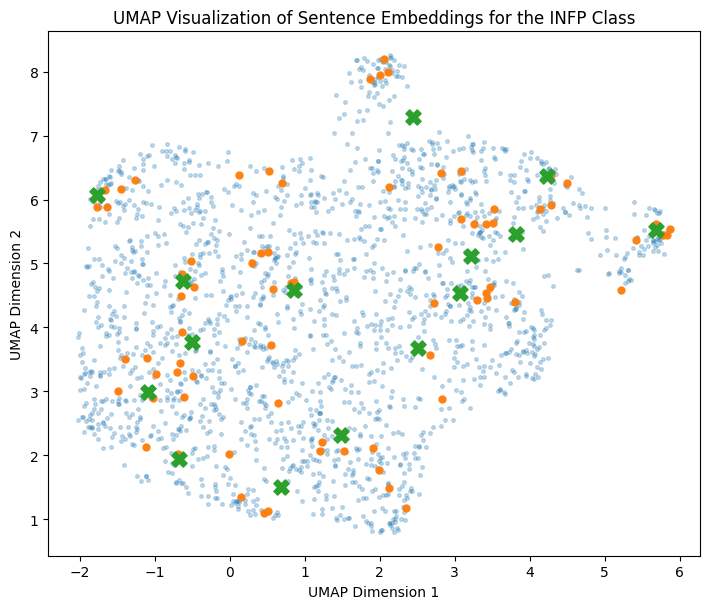

saved: ../Data/split_cc_viz/viz_INFP_selected.png


In [11]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import pairwise_distances

from sentence_transformers import SentenceTransformer

# Optional (UMAP). If not installed: pip install umap-learn
import umap

# =========================
# CONFIG (네 디렉토리 구조 반영)
# =========================
SPLIT_DIR = "../Data/split"  # train/val/test split 있는 곳
OUT_DIR = "../Data/split_cc_viz"  # 시각화 저장 폴더
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
RANDOM_STATE = 42

# 시각화는 너무 크면 안 예쁨 -> 한 클래스에서 샘플링
TARGET_CLASS = "INFP"  # 보고 싶은 타입 (INFP/INTP/INFJ 등)
N_SAMPLE = 2000  # 시각화용 샘플 개수 (2000~5000 추천)

# 클러스터 개수 (시각화용은 작게)
K_VIS = 15

# 각 클러스터에서 centroid 근처 몇 개 강조할지
PICK_PER_CLUSTER = 6

# embedding batch size
EMB_BATCH = 256

os.makedirs(OUT_DIR, exist_ok=True)

# =========================
# 1) Load train split (네 코드와 동일)
# =========================
train_path = os.path.join(SPLIT_DIR, "train.csv")
train_df = pd.read_csv(train_path)

train_df["mbti"] = train_df["mbti"].str.upper().str.strip()
train_df["body"] = train_df["body"].astype(str)

print(f"loaded train: {len(train_df):,}")

# =========================
# 2) Filter one class and sample
# =========================
df_c = train_df[train_df["mbti"] == TARGET_CLASS].copy()
if len(df_c) == 0:
    raise ValueError(f"No rows found for TARGET_CLASS={TARGET_CLASS}. Check labels.")

df_c = df_c.sample(min(N_SAMPLE, len(df_c)), random_state=RANDOM_STATE).reset_index(drop=True)
texts = df_c["body"].tolist()
print(f"viz class={TARGET_CLASS} sample={len(df_c):,}")

# =========================
# 3) Sentence-BERT embeddings (네 코드랑 동일 흐름)
# =========================
device = "cuda" if torch.cuda.is_available() else "cpu"
st_model = SentenceTransformer(MODEL_NAME, device=device)

X = st_model.encode(
    texts,
    batch_size=EMB_BATCH,
    show_progress_bar=True,
    convert_to_numpy=True
)
X = normalize(X, norm="l2", axis=1)  # cosine ~= euclidean on normalized vectors

# =========================
# 4) Coarse clustering (embedding space에서)
#    - 네 코드와 같은 MiniBatchKMeans 사용
# =========================
k = min(K_VIS, len(df_c))  # 혹시 샘플이 적을 때 대비
km = MiniBatchKMeans(
    n_clusters=k,
    random_state=RANDOM_STATE,
    batch_size=4096,
    n_init=5,
    max_iter=100,
    init="k-means++"
)
labels = km.fit_predict(X)
centers = km.cluster_centers_

# =========================
# 5) 2D projection for visualization (UMAP)  <-- 먼저!
# =========================
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.15,
    n_components=2,
    metric="cosine",
    random_state=RANDOM_STATE
)
X_2d = reducer.fit_transform(X)

# =========================
# 6) Representative points + centroid-nearest points
# =========================
centers = normalize(centers, norm="l2", axis=1)  # centroid도 normalize

repr_idx = []        # 각 클러스터 대표 1개
selected_local = []  # 각 클러스터에서 centroid 근처 PICK_PER_CLUSTER개

for cl in range(k):
    idx = np.where(labels == cl)[0]
    if len(idx) == 0:
        continue

    Xcl = X[idx]
    d = pairwise_distances(Xcl, centers[cl][None, :], metric="euclidean").ravel()

    # 대표점 1개
    repr_idx.append(idx[np.argmin(d)])

    # centroid 근처 여러 개
    topk = idx[np.argsort(d)[:min(PICK_PER_CLUSTER, len(idx))]]
    selected_local.extend(topk.tolist())

# numpy 인덱싱용으로 int dtype 강제
repr_idx = np.array(sorted(set(repr_idx)), dtype=np.int64)
selected_local = np.array(sorted(set(selected_local)), dtype=np.int64)

repr_2d = X_2d[repr_idx]

print(f"repr points: {len(repr_idx)}")
print(f"selected (centroid-nearest) points: {len(selected_local)}")

# =========================
# 7) (옵션) 2D pseudo-centroids (cluster mean in 2D)
# =========================
centers_2d = np.zeros((k, 2))
for cl in range(k):
    cl_mask = (labels == cl)
    if cl_mask.sum() > 0:
        centers_2d[cl] = X_2d[cl_mask].mean(axis=0)

# =========================
# 8) Plot 1: clusters + representative points
# =========================
plt.figure(figsize=(7.2, 6.2))
for cl in range(k):
    cl_mask = (labels == cl)
    plt.scatter(X_2d[cl_mask, 0], X_2d[cl_mask, 1], s=8, alpha=0.55)

plt.scatter(repr_2d[:, 0], repr_2d[:, 1], s=120, marker="X")
plt.title(f"UMAP + KMeans clusters (class={TARGET_CLASS}, n={len(df_c)})")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()

out1 = os.path.join(OUT_DIR, f"viz_{TARGET_CLASS}_clusters.png")
plt.savefig(out1, dpi=250)
plt.show()
print("saved:", out1)

# =========================
# 9) Plot 2: highlight selected centroid-nearest samples
# =========================
plt.figure(figsize=(7.2, 6.2))
plt.scatter(X_2d[:, 0], X_2d[:, 1], s=7, alpha=0.25)

if len(selected_local) > 0:
    plt.scatter(X_2d[selected_local, 0], X_2d[selected_local, 1], s=25, alpha=0.95)

plt.scatter(repr_2d[:, 0], repr_2d[:, 1], s=120, marker="X")
plt.title(
    f"UMAP Visualization of Sentence Embeddings for the {TARGET_CLASS} Class"
)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.tight_layout()

out2 = os.path.join(OUT_DIR, f"viz_{TARGET_CLASS}_selected.png")
plt.savefig(out2, dpi=250)
plt.show()
print("saved:", out2)